In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [3]:
mat_file1 = io.loadmat('2014_Dataset1.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']

In [4]:
def make_input_output(p1,p2):
    global k
    for i in range(len(p1)-10):
        for j in range(20):
            if i==0:
                if j==0:
                    auto_input = p1[0]
                elif 1<= j <= 9:
                    auto_input = np.hstack((auto_input,p1[j]))
                else:
                    auto_input = np.hstack((auto_input,p2[j-10]))
            else:
                if j==0:
                    k = p1[i]
                elif 1<= j <= 9:
                    k = np.hstack((k,p1[j+i]))
                else:
                    k = np.hstack((k,p2[j-10+i]))
        if i != 0:           
            auto_input = np.vstack((auto_input,k))
        
        if i==0:
            auto_output1 = p1[10]
            auto_output2 = p2[10]
        else:
            auto_output1 = np.vstack((auto_output1,p1[10+i]))
            auto_output2 = np.vstack((auto_output2,p2[10+i]))               
        
    return auto_input,auto_output1,auto_output2 

In [5]:
i,o1,o2 = make_input_output(p1,p2)

In [6]:
i

array([[   5.819,    5.825,    5.835, ...,  203.05 ,  201.77 ,  203.05 ],
       [   5.825,    5.835,    5.847, ...,  201.77 ,  203.05 ,  203.42 ],
       [   5.835,    5.847,    5.844, ...,  203.05 ,  203.42 ,  203.24 ],
       ..., 
       [   5.932,    5.935,    5.941, ...,  194.08 ,  193.9  ,  195.   ],
       [   5.935,    5.941,    5.929, ...,  193.9  ,  195.   ,  195.91 ],
       [   5.941,    5.929,    5.938, ...,  195.   ,  195.91 ,  194.26 ]])

In [7]:
o2

array([[ 203.42],
       [ 203.24],
       [ 202.87],
       ..., 
       [ 195.91],
       [ 194.26],
       [ 193.53]])

In [20]:
l = 500
K1 = GPy.kern.RBF(input_dim=20)
K2 = GPy.kern.RBF(input_dim=20)

# lcm = GPy.util.multioutput.LCM(input_dim=20,num_outputs=2,kernels_list=[K1])
# ar_gp = GPy.models.GPCoregionalizedRegression([i[0:l],i[0:l]],[o1[0:l],o2[0:l]],kernel = lcm)

ar_gp = GPy.models.GPRegression(i[0:l],o1[0:l],K1)
ar_gp.optimize()

ar_gp2 = GPy.models.GPRegression(i[0:l],o2[0:l],K2)
ar_gp2.optimize()

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:35: RuntimeWarning:overflow encountered in square
 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:38: RuntimeWarning:invalid value encountered in multiply


In [21]:
ind = np.arange(10,10+l,1)[:,None]

for j in range(len(ind)):
    mean, var = ar_gp.predict(i[j:j+1],kern=ar_gp.kern,likelihood=ar_gp.likelihood)
    mean2, var2 = ar_gp2.predict(i[j:j+1],kern=ar_gp2.kern,likelihood=ar_gp2.likelihood)
#     mean = np.hstack((mean[0],mean[1]))
    if j==0:
        output = mean
        output2 = mean2
    else:
        output = np.vstack((output,mean))
        output2 = np.vstack((output2,mean2))

In [22]:
for j in range(len(ind)):
    if j==0:
        bi = i[j:j+1].copy()
    else:
        bii = bi.copy()
        bi = bi.copy()
        bi[0][0:9] = bii[0][1:10]
        bi[0][9] = mean_b
        bi[0][10:19] = bii[0][11:20]
        bi[0][19] = mean_b2
#     X_b,Y_b,I_b = build_XY([bi,bi],[o1[j],o2[j]])
    mean_b, var_b = ar_gp.predict(bi,kern=ar_gp.kern,likelihood=ar_gp.likelihood)
    mean_b2, var_b2 = ar_gp2.predict(bi,kern=ar_gp2.kern,likelihood=ar_gp2.likelihood)
#     mean_b = np.hstack((mean_b[0],mean_b[1]))
    if j==0:
        output_b = mean_b
        output_b2 = mean_b2
    else:
        output_b = np.vstack((output_b,mean_b))
        output_b2 = np.vstack((output_b2,mean_b2))

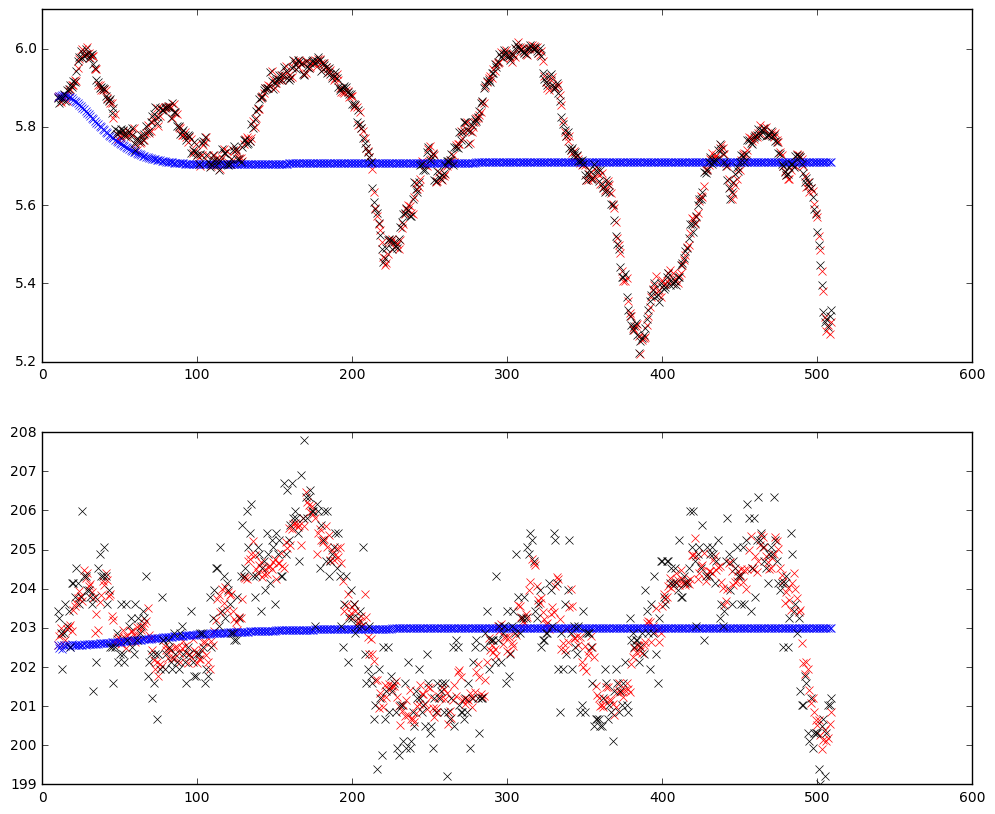

In [23]:
fig = pb.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1.plot(ind,output,'kx',color='red')
ax1.plot(ind,output_b,'kx',color='blue')
ax1.plot(ind,o1[0:l],'kx')
ax2 = fig.add_subplot(212)
ax2.plot(ind,output2,'kx',color='red')
ax2.plot(ind,output_b2,'kx',color='blue')
ax2.plot(ind,o2[0:l],'kx')

plt.show()

In [18]:
output_b2

array([[-48.51741873],
       [-47.43642778],
       [-46.89621225],
       [-46.04393475],
       [-45.13075013],
       [-43.75719401],
       [-42.53006991],
       [-41.66875565],
       [-40.83163043],
       [-40.48679192],
       [-39.58016453],
       [-39.47446294],
       [-39.56806373],
       [-39.59604209],
       [-39.64203765],
       [-39.71355344],
       [-39.74280409],
       [-39.75699009],
       [-39.77175574],
       [-39.77564279],
       [-39.78592761],
       [-39.78466114],
       [-39.78230284],
       [-39.78061227],
       [-39.77917532],
       [-39.77797152],
       [-39.77734051],
       [-39.77701401],
       [-39.77679313],
       [-39.77674782],
       [-39.77670164],
       [-39.77676806],
       [-39.77683432],
       [-39.77688016],
       [-39.77691198],
       [-39.77693336],
       [-39.77694341],
       [-39.77694732],
       [-39.77694872],
       [-39.7769476 ],
       [-39.77694642],
       [-39.77694444],
       [-39.77694293],
       [-39